In [1]:
import os
import tensorflow as tf
from google.protobuf import text_format
from protos import pipeline_pb2
from modeling import trainer

image_dir = "/afs/cs.pitt.edu/usr0/key36/work2/WSSGG/data-vspnet/images"
model_dir = "/afs/cs.pitt.edu/usr0/key36/work2/WSSGG/logs.basic.trainwv/rnn_it3_lyr2/"
config_file = os.path.join(model_dir, "pipeline.pbtxt")

for gpu in tf.config.experimental.list_physical_devices('GPU'):
  tf.config.experimental.set_memory_growth(gpu, True)

with tf.io.gfile.GFile(config_file, 'r') as fp: 
  pipeline_proto = text_format.Merge(fp.read(), pipeline_pb2.Pipeline())
batch_generator = trainer.predict(pipeline_proto, model_dir)

/afs/cs.pitt.edu/projects/kovashka/keren3/WSSGG/python/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


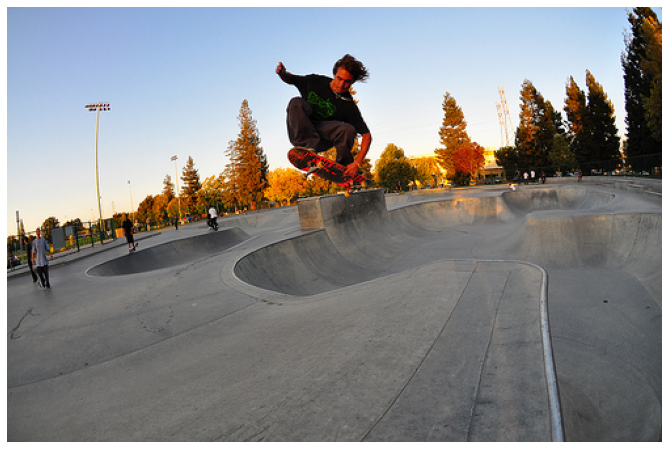

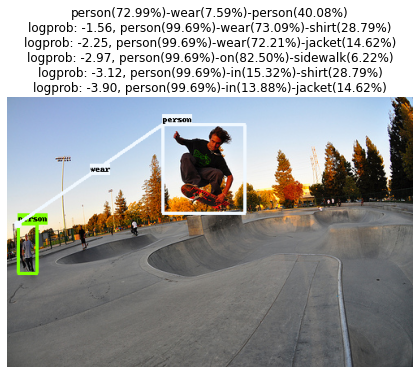

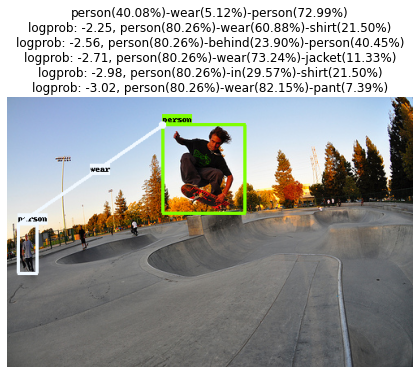

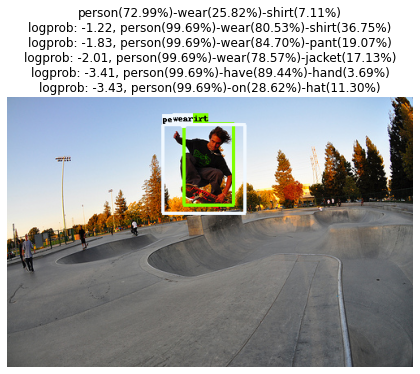

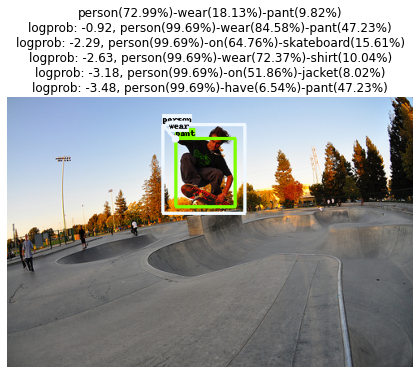

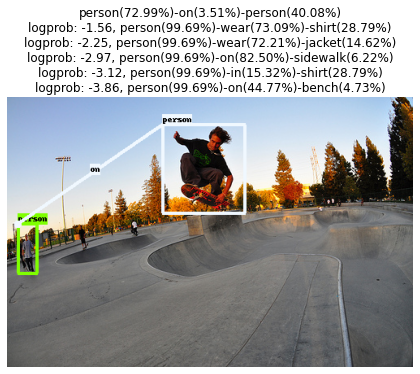

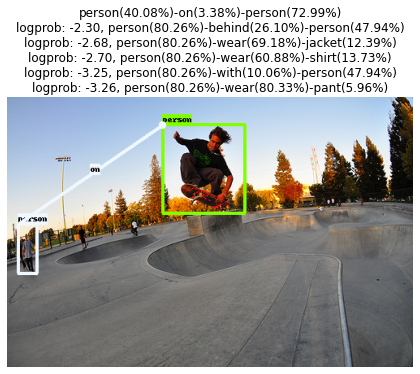

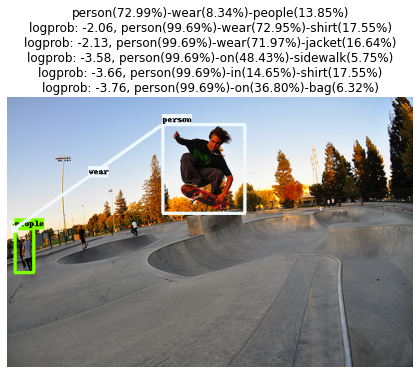

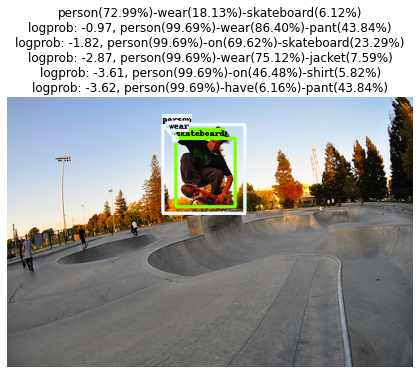

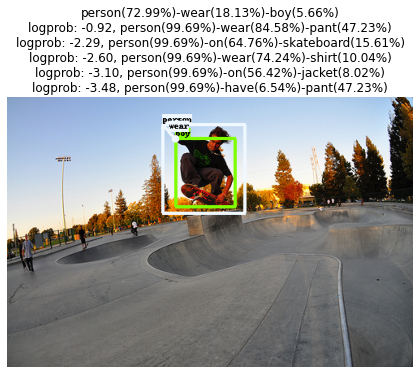

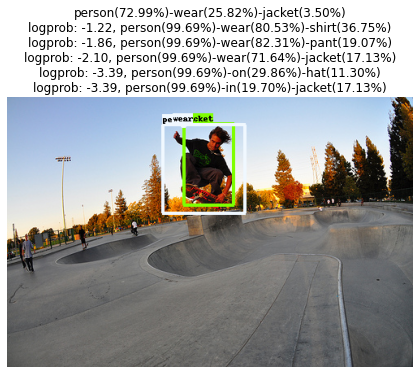

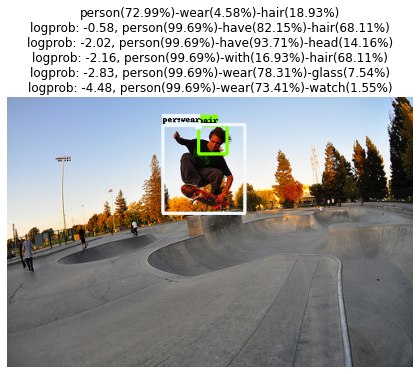

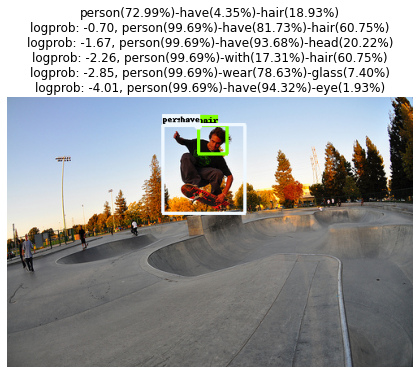

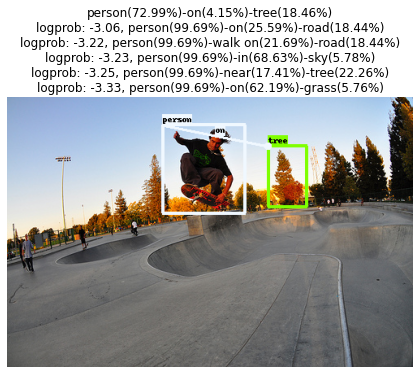

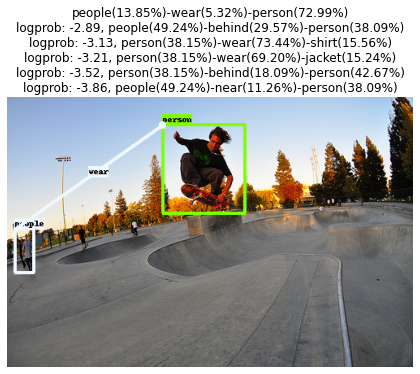

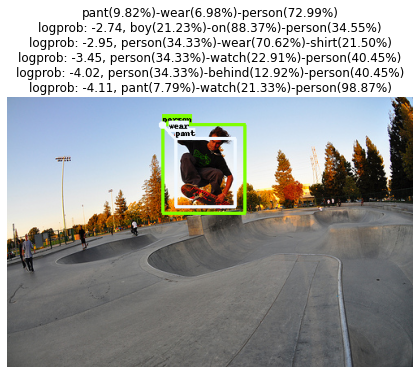

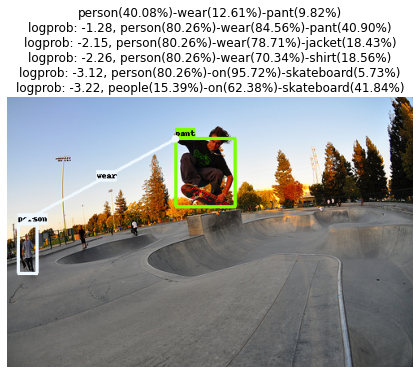

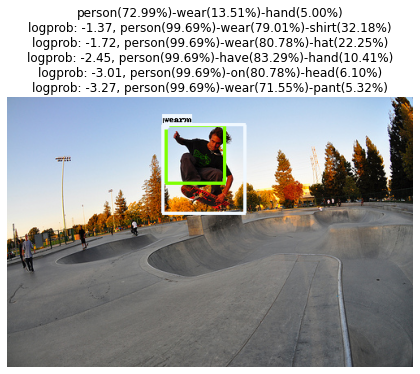

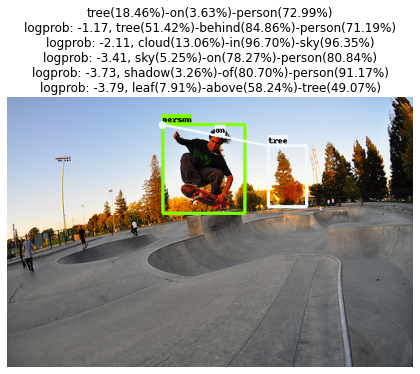

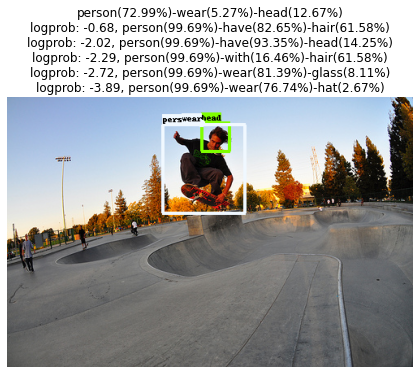

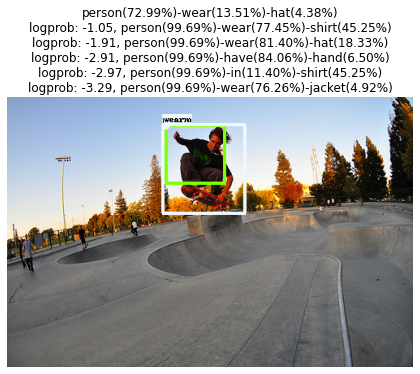

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
from modeling.utils import visualization

%matplotlib inline

try:
  i = next(example_id_generator)
except Exception as ex:
  example = next(batch_generator)
  example_id_generator = (i for i in range(len(example['id'])))
  i = next(example_id_generator)

# Predictions.
image_id = example['id'][i]
subjects = example['triple_proposal/subject'][i]
subject_boxes = example['triple_proposal/subject/box'][i]
subject_scores = example['triple_proposal/subject/score'][i]
predicates = example['triple_proposal/predicate'][i]
predicate_scores = example['triple_proposal/predicate/score'][i]
objects = example['triple_proposal/object'][i]
object_boxes = example['triple_proposal/object/box'][i]
object_scores = example['triple_proposal/object/score'][i]

scores_refined = example['beam_refine/accum_log_probs'][i]
subjects_refined = example['beam_refine/subject'][i]
subject_scores_refined = example['beam_refine/subject/score'][i]
predicates_refined = example['beam_refine/predicate'][i]
predicate_scores_refined = example['beam_refine/predicate/score'][i]
objects_refined = example['beam_refine/object'][i]
object_scores_refined = example['beam_refine/object/score'][i]

# Load original image.
image = Image.open(os.path.join(image_dir, '%i.jpg' % image_id))
image = np.array(image)

# Show original image.
plt.figure(figsize=(16, 8))
plt.subplot(1, 1, 1)
plt.imshow(image)
plt.axis('off')

# Show ground-truth and predicted tuples.
count = 0
for prediction_id, (sub, sub_box, sub_score, 
                    pred, pred_score, 
                    obj, obj_box, obj_score, 
                    sub_ref, sub_scores_ref,
                    pred_ref, pred_scores_ref, 
                    obj_ref, obj_scores_ref,
                    scores_ref
                   ) in enumerate(
    zip(subjects, subject_boxes, subject_scores,
        predicates, predicate_scores, 
        objects, object_boxes, object_scores, 
        subjects_refined, subject_scores_refined, 
        predicates_refined, predicate_scores_refined, 
        objects_refined, object_scores_refined, 
        scores_refined)):

  if count >= 20: break
  
  plt.figure(figsize=(16, 8))
    
  # Prediction.
  title = "%s(%.2lf%%)-%s(%.2lf%%)-%s(%.2lf%%)" % (
      sub.decode('ascii'), 100 * sub_score, 
      pred.decode('ascii'), 100 * pred_score, 
      obj.decode('ascii'), 100 * obj_score)
  for s, s_score, p, p_score, o, o_score, score in zip(
      sub_ref, sub_scores_ref, pred_ref, pred_scores_ref, obj_ref, obj_scores_ref, scores_ref):
    title += '\nlogprob: %.2lf, %s(%.2lf%%)-%s(%.2lf%%)-%s(%.2lf%%)' % (
        score, s.decode('ascii'), s_score * 100, p.decode('ascii'), p_score * 100, o.decode('ascii'), o_score * 100)

  plt.subplot(1, 2, count % 2 + 1).set_title(title)
  image_with_prediction = visualization.draw_bounding_box_py_func_fn(
      image.copy(), 2, [sub_box, obj_box], [sub, obj], None)
  image_with_prediction = visualization.draw_arrow_py_func_fn(
      image_with_prediction, 1, [sub_box[0]], [sub_box[1]], [obj_box[0]], [obj_box[1]], [pred], None)
  plt.imshow(image_with_prediction)
  plt.axis('off')
    
  
  count += 1
    